# Importing libraries

In [4]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import numpy.linalg as la
import time

# Generating the Data Points

In [5]:
''' Create a dataset of 10,000 data points by randomly generating samples with 2 features,
and assign them to 2 distinct classes
'''

''' Represent the data points with 'X' and labels with 'y' and replacing labeles '0' to '-1' 
'''

X, y = make_blobs(n_samples = 10000, centers = 2, n_features = 2,
                  cluster_std = 1, shuffle = True, random_state = 123)

''' Replace label '0' with '-1'
'''
y[y==0] = -1

''' Split the data into 3% labeled and 97% unlabeled subsets
'''
indices = np.arange(10000)

x_labeled, x_unlabeled, y_labeled, y_unlabeled, labeled_index, unlabeled_index = train_test_split(X, y, indices,
                                                                                                  test_size= 0.97,
                                                                                                  random_state=2,
                                                                                                  stratify=y)
''' Assign the value of 0 to the variable 'y_unlabeled' 
while preserving the actual labels for future comparison against the predicted labels
'''

y_actual = y[unlabeled_index]
y[unlabeled_index]=0

print('The number of unlabeled data = {}'. format(np.count_nonzero(y == 0)))
print('The number of labeled data = {}'. format(np.count_nonzero((y == -1) | (y == 1))))

The number of unlabeled data = 9700
The number of labeled data = 300


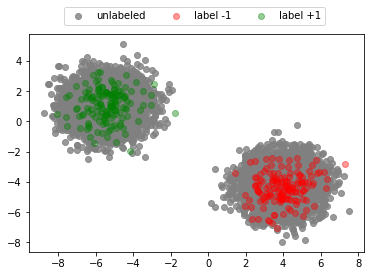

In [6]:
'''Scatter plot of data points
'''
plt.scatter(X[y==0,0],X[y==0,1], c='gray', alpha=0.8, label='unlabeled')
plt.scatter(X[y==-1,0],X[y==-1,1], c='red', alpha=0.4, label='label -1')
plt.scatter(X[y==1,0],X[y==1,1], c='green', alpha=0.4, label='label +1')
plt.legend(bbox_to_anchor =(0.9, 1.15), ncol = 3)
plt.show()

In [7]:
'''Gradient of cost function '''

def grad_func(y, d, sum_W, sum_W_unlab, W, W_unlab):
    return 2*(y[d]*(sum_W[d]+sum_W_unlab[d]) - np.dot(y_target.T, W[:,d]) - np.dot(W_unlab[d,:], y))

# Similarity Measure Using Euclidean Distance

In [8]:
X_labeled = X[labeled_index]
X_unlabeled = X[unlabeled_index]

'''Compute the similarity matrix between labeled and unlabeled samples
'''
W = np.exp(-0.5 * euclidean_distances(X_labeled, X_unlabeled)**2)

'''Compute the similarity matrix between unlabeled samples
'''
D = euclidean_distances(X_unlabeled)
W_unlab = np.exp(-0.5 * D**2)

'''Make W_unlab symmetric
'''
W_unlab = 0.5 * (W_unlab + W_unlab.T)

# Computing Lipschitz constants and Fixed Stepsizes

In [9]:
'''sum of columns for W and W_unlab
''' 
sum_W = np.sum(W, axis=0)
sum_W_unlab = np.sum(W_unlab, axis=0)

y_target = y[labeled_index]

'''Lipschitz constant
''' 
L = 2 * la.norm(np.diag(sum_W + sum_W_unlab) - W_unlab, 2)

GD_stepsize = 1.0 / L 
BCGD_stepsizes = 1.0 / (2 * (sum_W + sum_W_unlab - np.diag(W_unlab)))

print(f"Lipschitz constant: {L}")
print(f"GD stepsize: {GD_stepsize}")
print(f"BCGD stepsizes: {BCGD_stepsizes}")

Lipschitz constant: 4982.641268270627
GD stepsize: 0.00020069676827187674
BCGD stepsizes: [0.00040344 0.00039953 0.00033094 ... 0.00030245 0.00021396 0.00040354]


In [10]:
'''The accuracy_score function predicts labels based on the sign of the components of y_predicted.
If a component is non-negative, it predicts 1; otherwise, it predicts -1
'''

def accuracy_score(y_predicted, y_true):
    y_pred = np.ones(y_predicted.shape[0]) 
    y_pred[y_predicted < 0] = -1 
    accuracy = np.sum((y_true - y_pred) == 0)/y_predicted.shape[0]
    return accuracy

In [11]:
'''The initial point is randomly generated,where each component
is uniformly chosen at random from the interval [-1, 1]
'''
np.random.seed(123)
y_init = 2*np.random.rand(unlabeled_index.shape[0])-1

# Standard Gradient Descent

In [12]:
def gradient_descent(y_init, y_actual, learning_rate, sum_W, sum_W_unlab, W, W_unlab,
                     stop_threshold=1e-8, max_iterations=10000):
    '''starting time
    '''
    start = time.time()
    times = [] 
    accuracy = []
    y_updated = y_init.copy() 
    gradient = np.ones(y_init.shape[0])  

    for iterations in range(1, max_iterations + 1):
        for j in range(y_updated.shape[0]): 
            gradient[j] = grad_func(y_updated, j, sum_W, sum_W_unlab, W, W_unlab)
            
            '''Updating step'''
            y_updated[j] -= learning_rate * gradient[j]
            
        
        accuracy.append(accuracy_score(y_updated, y_actual))
        times.append(time.time() - start)

        sum_gradient_squared = np.sum(gradient ** 2)
        if np.sqrt(sum_gradient_squared) <= stop_threshold:
            break

    return y_updated, gradient, iterations, accuracy, times

# Randomized  BCGD

In [13]:
def BCGD_randomized(y_init, y_actual, learning_rate, sum_W, sum_W_unlab, W, W_unlab,
                    stop_threshold=1e-8, max_iterations=10000):
  
    '''starting time
    '''
    start = time.time()  
    times = []  
    accuracy = []  
    y_updated = y_init.copy()  
    sum_gradient_squared = 1  
  
    for iterations in range(1, max_iterations + 1):
        block = np.random.randint(0, y_init.shape[0])
        gradient = np.zeros(y_init.shape[0])
        gradient[block] = grad_func(y_updated, block, sum_W, sum_W_unlab, W, W_unlab)
        
        '''Updating step'''
        y_updated = y_updated - learning_rate[block] * gradient

       
        accuracy.append(accuracy_score(y_updated, y_actual))
        times.append(time.time() - start)   

        sum_gradient_squared = np.sum(gradient ** 2)
        if np.sqrt(sum_gradient_squared) <= stop_threshold:
            break
  
    return y_updated, gradient, iterations, accuracy, times

# BCGD_Gauss_Southwell

In [14]:
def BCGD_Gauss(y_init, y_actual, learning_rate, sum_W, sum_W_unlab, W, W_unlab,
               stop_threshold=1e-8, max_iterations=10000):
    
    '''starting time
    '''
    start = time.time() 
    iterations = 0 
    times = [] 
    accuracy = []
    y_previous = y_init
    y_updated = np.zeros(y_init.shape[0]) 
    sum = 1 

    while np.sqrt(sum)>stop_threshold and iterations < max_iterations:
        iterations += 1
        gradient= np.zeros(y_init.shape[0]) 
        for j in range(y_init.shape[0]):
            gradient[j] = np.abs(grad_func(y_previous, j, sum_W, sum_W_unlab, W, W_unlab)) 
          
        block = np.argmax(gradient) 
        gradient= np.zeros(y_init.shape[0]) 
        gradient[block] = grad_func(y_previous, block, sum_W, sum_W_unlab, W, W_unlab)
        
        '''Updating step'''
        y_updated = y_previous - learning_rate[block]*gradient
        y_previous = y_updated

        # computation of accuracy score
        accuracy.append(accuracy_score(y_updated, y_actual))

        # we store the time elapsed so far
        times.append(time.time()-start)    

        sum=0
        for j in range(y_init.shape[0]):
            gradient[j] = grad_func(y_updated, j, sum_W, sum_W_unlab, W, W_unlab)
            sum += np.power(gradient[j],2)
  
    return (y_updated, gradient, iterations, accuracy, times)

# Results

number of iterations: 1861
accuracy score: 1.0


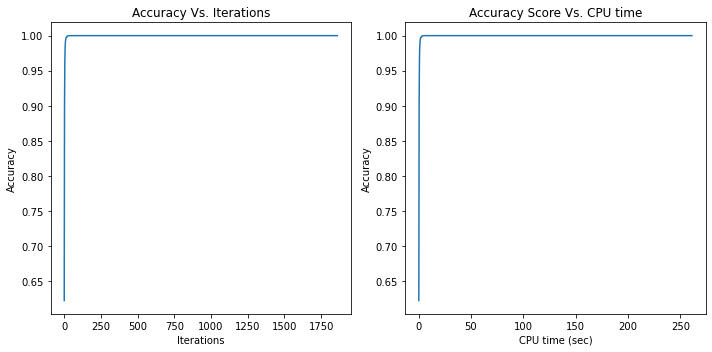

In [15]:
GD_output = gradient_descent(y_init, y_actual, GD_stepsize, sum_W, sum_W_unlab, W, W_unlab)

num_iterations = GD_output[2]
accuracy_1 = GD_output[3][-1]

output_string = "number of iterations: {}\naccuracy score: {}".format(num_iterations, accuracy_1)
print(output_string)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

'''Plot Iterations Vs. Accuracy
'''
axes[0].plot(range(GD_output[2]), GD_output[3])

axes[0].set_title('Accuracy Vs. Iterations')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Accuracy')


'''Plot CPU time Vs. Accuracy
'''
axes[1].plot(GD_output[4], GD_output[3])

axes[1].set_title('Accuracy Score Vs. CPU time')
axes[1].set_xlabel('CPU time (sec)')
axes[1].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()

number of iterations: 20000
accuracy score: 0.9381443298969072


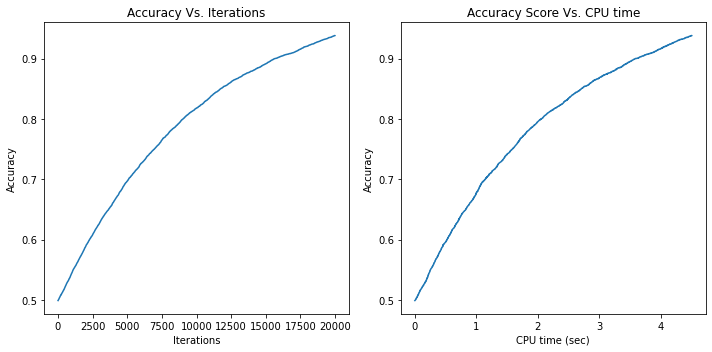

In [16]:
BCGD_R_output = BCGD_randomized(y_init, y_actual, BCGD_stepsizes, sum_W, sum_W_unlab, W, W_unlab, max_iterations=20000)

num_iterations = BCGD_R_output[2]
accuracy_2= BCGD_R_output[3][-1]  # Renamed the variable to 'accuracy' to avoid naming conflict

output_string = "number of iterations: {}\naccuracy score: {}".format(num_iterations, accuracy_2)
print(output_string)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

'''Plot Iterations Vs. Accuracy
''' 
axes[0].plot(range(BCGD_R_output[2]), BCGD_R_output[3])

axes[0].set_title('Accuracy Vs. Iterations')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Accuracy')


'''Plot CPU time Vs. Accuracy
'''
axes[1].plot(BCGD_R_output[4], BCGD_R_output[3])

axes[1].set_title('Accuracy Score Vs. CPU time')
axes[1].set_xlabel('CPU time (sec)')
axes[1].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()

number of iterations: 10000
accuracy score: 0.9922680412371134


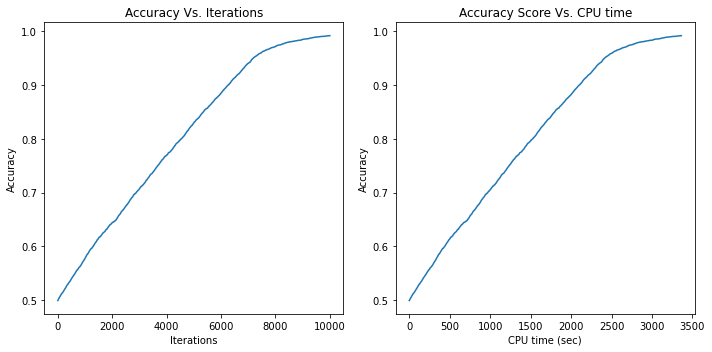

In [17]:
BCGD_GS_output = BCGD_Gauss(y_init, y_actual, BCGD_stepsizes, sum_W, sum_W_unlab, W, W_unlab)

num_iterations = BCGD_GS_output[2]
accuracy_3 = BCGD_GS_output[3][-1]

output_string = f"number of iterations: {num_iterations}\naccuracy score: {accuracy_3}"
print(output_string)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

'''Plot Iterations Vs. Accuracy
''' 
axes[0].plot(range(BCGD_GS_output[2]), BCGD_GS_output[3])

axes[0].set_title('Accuracy Vs. Iterations')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Accuracy')


'''Plot CPU time Vs. Accuracy
'''
axes[1].plot(BCGD_GS_output[4], BCGD_GS_output[3])

axes[1].set_title('Accuracy Score Vs. CPU time')
axes[1].set_xlabel('CPU time (sec)')
axes[1].set_ylabel('Accuracy')

fig.tight_layout()
plt.show()